In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
import dotenv
from langchain_core.prompts import PromptTemplate
import json
import pandas as pd
from Text_preprocessing import Text_preprocessing
from langchain_community.document_loaders import DataFrameLoader
from langchain_community.vectorstores import chroma as Chroma
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
import llmModels 
import prompts

dotenv.load_dotenv()

### PARAMETER CHECKPOINT ####

#Open AI
chatModelAI = ChatOpenAI(temperature=0)

####Choose chat model

#  Llama 2 13 B chat
# chatModel_llama13b = llmModels.loadLlamma()

# # # Mistral 7B chat
# chatModel_mistral7b = llmModels.loadMistral7b()

# #70B
# chatModel_llama70b = llmModels.loadLlama2_70B()

## Llama 3 8B
chatModel_llama3_8B = llmModels.loadLlama3_8B() 

##FSD_1777
dataPath = "/home/mbhatti/mnt/d/LLM-repo1/models/langchain_implementation/FSD1777_Oct23.json"
dateFrom = "2023-10-19T18:00:00+00:00" #2023-10-19T18:58:41Z for 200 tweets
dateTo = "2023-10-19T23:59:00+00:00"


/home/mbhatti/miniconda3/envs/llama/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [01:21<00:00, 20.43s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
"""Load relevant fields of flood tags api json response"""
def json_dataloader(dataPath = dataPath, dateFrom = dateFrom, dateTo = dateTo):
    # Load json and extract relevant records in pandas df
    with open(dataPath, 'r') as json_file:
        response_dict = json.load(json_file)

    # Convert to pandas df    
    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(response_dict)
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop(columns=['id','tag_class', 'source', 'lang', 'urls','locations'])

    #Get data between thresholds
    threshold_datetime_lower = pd.to_datetime(dateFrom)
    threshold_datetime_upper = pd.to_datetime(dateTo)
    df = df[df['date'] >= threshold_datetime_lower]
    df = df[df['date'] <= threshold_datetime_upper]

    #Remove duplicates
    df  = df.drop_duplicates(subset=["text"], keep=False)
    #Pre-process
    preprocess = Text_preprocessing(df)
    df = preprocess.preprocess()
    #Covert date to string
    df['date'] = df['date'].astype(str)
    return df

def bgeEmbeddings():
    model_name = "BAAI/bge-large-en-v1.5"
    # model_name = "BAAI/bge-m3"
    model_kwargs = {'device': 'cuda'}
    encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
    model = HuggingFaceBgeEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )
    return model

def data_embedding(data : list, eModel = "bge-large-en-v1.5", rType = "Query", metric = "L2", lang = "en"):
    """Vectorize the data using OpenAI embeddings and store in Chroma db"""
    if lang == "en":
        if eModel != "bge-large-en-v1.5":
            embeddings = OpenAIEmbeddings()
        else:
            embeddings = bgeEmbeddings()
        
        if (rType == "Hyde"):
            embeddings = hydeEmbedder(embeddings)

    if lang == "ja": 
        embeddings = bgeEmbeddings()


    documents = []
    loader = DataFrameLoader(data, page_content_column="text")
    documents.extend(loader.load())

    #Change this -- removal of duplicates
    db = Chroma.Chroma.from_documents(documents,embeddings)
    if db._client.list_collections() != None:
        for collection in db._client.list_collections():
            ids = collection.get()['ids']
            print('REMOVE %s document(s) from %s collection' % (str(len(ids)), collection.name))
            if len(ids): collection.delete(ids)

    #Create a vector store
    if metric == "cosine":
        db = Chroma.Chroma.from_documents(documents,embeddings, collection_metadata={"hnsw:space": "cosine"})
    else:
        db = Chroma.Chroma.from_documents(documents,embeddings)
    print(len(db._collection.get()['ids']))
    return db

In [12]:
"""For running a single query"""
def predictions_response(question, eModel = "bge-large-en-v1.5", rType = "Query", rerank = False,k = 60, lang = "en"):
    
    #  LLM initialisation
    model = chatModel_llama3_8B

    

    # Load the data from source
    # data = dataframe_dataloader()
    data = json_dataloader()
    # ### remove brechin
    # import spacy
    # # Load the English language model
    # nlp = spacy.load("en_core_web_lg")
    # #Implementation on the dataframe
    # # Predefined list of entities to match
    # predefined_entities = ["Brechin"]

    # # Function to extract entities from text
    # def extract_entities(text):
    #     doc = nlp(text)
    #     return [ent.text for ent in doc.ents]

    # # Iterate over the DataFrame and delete rows if entities match
    # for index, row in data.iterrows():
    #     entities = extract_entities(row["text"])
    #     if any(entity in predefined_entities for entity in entities):
    #         data.drop(index, inplace=True)


    # Loading pandas dataframe from picke file
    # data = dataframe_dataloader()

    # Convert to vector store
    vectorstore = data_embedding(data, eModel= eModel, rType= rType, lang = lang)
    
    # #Convert japanese tweets to english after retrieval
    # if lang == "ja":
    #     retriever = Custom_ja_Retriever(vectorstore=vectorstore.as_retriever(search_kwargs={'k': k}))

    if lang == "en":
        # Get retriever
        if rerank == True:
            retriever = CustomRetriever(vectorstore=vectorstore.as_retriever(search_kwargs={'k': k}))
        else:
            retriever = vectorstore.as_retriever(search_kwargs={'k': k})
    
    if lang == "ja":
        retriever = Custom_ja_Retriever(vectorstore=vectorstore.as_retriever(search_kwargs={'k': k}))


    default_prompt = PromptTemplate(template = prompts.prompt_template_llama3_default, input_variables = ['question', 'context'])
    default_chain = RetrievalQA.from_chain_type(llm = model,
                            chain_type='stuff',
                            retriever=retriever,
                            chain_type_kwargs={"prompt": default_prompt},
                            return_source_documents=True
                            )
    
    ans = default_chain.invoke(question)
    print(ans['query'])
    print(ans['result'])
    print(ans['source_documents'])


In [13]:
prompt = "Any deaths reported? Where?"
predictions_response(prompt, k = 20)

ValueError: You must provide an embedding function to compute embeddings.https://docs.trychroma.com/embeddings

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# JSON data
data = [
    {'location': 'North Sea', 'latitude': 56.0, 'longitude': 3.0},
    {'location': 'North Shields', 'latitude': 55.008, 'longitude': -1.447},
    {'location': 'South Shields', 'latitude': 54.998, 'longitude': -1.432},
    {'location': 'Barbourne (Worcester)', 'latitude': 52.204, 'longitude': -2.224},
    {'location': 'River Maun (near Retford)', 'latitude': 53.322, 'longitude': -0.943},
    {'location': 'Bridlington (Yorkshire)', 'latitude': 54.084, 'longitude': -0.200},
    {'location': 'Scarborough (Yorkshire)', 'latitude': 54.280, 'longitude': -0.402},
    {'location': 'Tyne (at North and South Shields)', 'latitude': 55.0, 'longitude': -1.45},
    {'location': 'Aberdeenshire', 'latitude': 57.149, 'longitude': -2.094},
    {'location': 'Angus', 'latitude': 56.704, 'longitude': -2.890},
    {'location': 'Dundee', 'latitude': 56.462, 'longitude': -2.970},
    {'location': 'Perth & Kinross', 'latitude': 56.395, 'longitude': -3.431},
    {'location': 'Inverurie', 'latitude': 57.284, 'longitude': -2.379},
    {'location': 'Perthshire', 'latitude': 56.704, 'longitude': -3.729},
    {'location': 'Findhorn', 'latitude': 57.655, 'longitude': -3.608},
    {'location': 'Nairn', 'latitude': 57.583, 'longitude': -3.872},
    {'location': 'Moray', 'latitude': 57.613, 'longitude': -3.308},
    {'location': 'Speyside region', 'latitude': 57.476, 'longitude': -3.333},
    {'location': 'Brechin (Angus)', 'latitude': 56.731, 'longitude': -2.656},
    {'location': 'River Don (Aberdeenshire)', 'latitude': 57.167, 'longitude': -2.100},
    {'location': 'Blairgowrie', 'latitude': 56.591, 'longitude': -3.340},
    {'location': 'River Isla', 'latitude': 56.616, 'longitude': -3.340},
    {'location': 'Forfar (Angus)', 'latitude': 56.644, 'longitude': -2.888},
    {'location': 'Haughton (Nottinghamshire)', 'latitude': 53.233, 'longitude': -0.950},
    {'location': 'Milton (Nottinghamshire)', 'latitude': 53.283, 'longitude': -0.950},
    {'location': 'West Drayton (Nottinghamshire)', 'latitude': 53.250, 'longitude': -0.950},
    {'location': 'Sandsend (North Yorkshire)', 'latitude': 54.506, 'longitude': -0.671},
    {'location': 'Glenrothes', 'latitude': 56.196, 'longitude': -3.174},
    {'location': 'River South Esk (Angus)', 'latitude': 56.700, 'longitude': -2.650},
    {'location': 'Ireland', 'latitude': 53.142, 'longitude': -7.692}
]

# Convert JSON data to pandas DataFrame
df = pd.DataFrame(data)

# Convert latitude and longitude to geometry points
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Display the GeoDataFrame
# print(gdf)

,location,latitude,longitude,geometry
0,North Sea,56.000,3.000,POINT (3.00000 56.00000)
1,North Shields,55.008,-1.447,POINT (-1.44700 55.00800)
2,South Shields,54.998,-1.432,POINT (-1.43200 54.99800)
3,Barbourne (Worcester),52.204,-2.224,POINT (-2.22400 52.20400)
4,River Maun (near Retford),53.322,-0.943,POINT (-0.94300 53.32200)
5,Bridlington (Yorkshire),54.084,-0.200,POINT (-0.20000 54.08400)
6,Scarborough (Yorkshire),54.280,-0.402,POINT (-0.40200 54.28000)
7,Tyne (at North and South Shields),55.000,-1.450,POINT (-1.45000 55.00000)
8,Aberdeenshire,57.149,-2.094,POINT (-2.09400 57.14900)
9,Angus,56.704,-2.890,POINT (-2.89000 56.70400)


contextily not installed, basemap not added


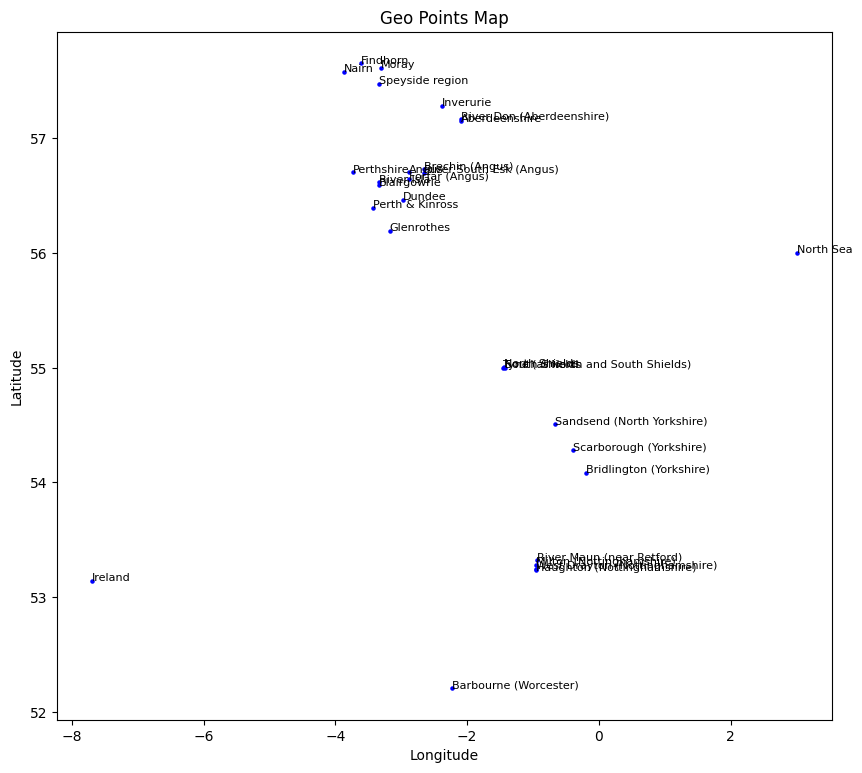

In [4]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=5)

# Add a basemap
ctx = None
try:
    import contextily as ctx
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
except ImportError:
    print("contextily not installed, basemap not added")

# Annotate locations
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['location']):
    ax.text(x, y, label, fontsize=8)

plt.title('Geo Points Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [9]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium

# JSON data
data = [
    {'location': 'North Sea', 'latitude': 56.0, 'longitude': 3.0},
    {'location': 'North Shields', 'latitude': 55.008, 'longitude': -1.447},
    {'location': 'South Shields', 'latitude': 54.998, 'longitude': -1.432},
    {'location': 'Barbourne (Worcester)', 'latitude': 52.204, 'longitude': -2.224},
    {'location': 'River Maun (near Retford)', 'latitude': 53.322, 'longitude': -0.943},
    {'location': 'Bridlington (Yorkshire)', 'latitude': 54.084, 'longitude': -0.200},
    {'location': 'Scarborough (Yorkshire)', 'latitude': 54.280, 'longitude': -0.402},
    {'location': 'Tyne (at North and South Shields)', 'latitude': 55.0, 'longitude': -1.45},
    {'location': 'Aberdeenshire', 'latitude': 57.149, 'longitude': -2.094},
    {'location': 'Angus', 'latitude': 56.704, 'longitude': -2.890},
    {'location': 'Dundee', 'latitude': 56.462, 'longitude': -2.970},
    {'location': 'Perth & Kinross', 'latitude': 56.395, 'longitude': -3.431},
    {'location': 'Inverurie', 'latitude': 57.284, 'longitude': -2.379},
    {'location': 'Perthshire', 'latitude': 56.704, 'longitude': -3.729},
    {'location': 'Findhorn', 'latitude': 57.655, 'longitude': -3.608},
    {'location': 'Nairn', 'latitude': 57.583, 'longitude': -3.872},
    {'location': 'Moray', 'latitude': 57.613, 'longitude': -3.308},
    {'location': 'Speyside region', 'latitude': 57.476, 'longitude': -3.333},
    {'location': 'Brechin (Angus)', 'latitude': 56.731, 'longitude': -2.656},
    {'location': 'River Don (Aberdeenshire)', 'latitude': 57.167, 'longitude': -2.100},
    {'location': 'Blairgowrie', 'latitude': 56.591, 'longitude': -3.340},
    {'location': 'River Isla', 'latitude': 56.616, 'longitude': -3.340},
    {'location': 'Forfar (Angus)', 'latitude': 56.644, 'longitude': -2.888},
    {'location': 'Haughton (Nottinghamshire)', 'latitude': 53.233, 'longitude': -0.950},
    {'location': 'Milton (Nottinghamshire)', 'latitude': 53.283, 'longitude': -0.950},
    {'location': 'West Drayton (Nottinghamshire)', 'latitude': 53.250, 'longitude': -0.950},
    {'location': 'Sandsend (North Yorkshire)', 'latitude': 54.506, 'longitude': -0.671},
    {'location': 'Glenrothes', 'latitude': 56.196, 'longitude': -3.174},
    {'location': 'River South Esk (Angus)', 'latitude': 56.700, 'longitude': -2.650},
    {'location': 'Ireland', 'latitude': 53.142, 'longitude': -7.692}
]

# Convert JSON data to pandas DataFrame
df = pd.DataFrame(data)

# Convert latitude and longitude to geometry points
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Initialize a folium map centered around the UK
m = folium.Map(location=[55.3781, -3.4360], zoom_start=6)

# Add points to the map
for idx, row in gdf.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['location']).add_to(m)

# Save the map to an HTML file
# m.save('uk_scotland_map.html')

# If you want to display the map directly in a Jupyter Notebook, you can use:
m